In [21]:
!pip install nltk scikit-learn joblib pandas numpy

In [2]:
# ---------------------------------------------
# Imports
# ---------------------------------------------
import pandas as pd
import numpy as np
import re
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ---------------------------------------------
# Download de recursos NLTK
# ---------------------------------------------
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

print("NLTK pronto!")


NLTK pronto!


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gilberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gilberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# ---------------------------------------------
# Função de preprocessamento
# ---------------------------------------------
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

print("Função preprocess_text pronta.")


Função preprocess_text pronta.


In [4]:
!wget https://raw.githubusercontent.com/gilberto-maess/ibmr-check-spam/main/spam_ham_dataset.csv

--2025-11-15 16:34:07--  https://raw.githubusercontent.com/gilberto-maess/ibmr-check-spam/main/spam_ham_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400995 (5.2M) [text/plain]
Saving to: ‘spam_ham_dataset.csv.1’

spam_ham_dataset.cs 100%[===================>]   5.15M  25.5MB/s    in 0.2s    

2025-11-15 16:34:07 (25.5 MB/s) - ‘spam_ham_dataset.csv.1’ saved [5400995/5400995]



In [5]:
import pandas as pd
df = pd.read_csv("spam_ham_dataset.csv")
df.head()


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
print("Aplicando pré-processamento...")

df["Clean_Text"] = df["text"].apply(preprocess_text)

print("Concluído!")
df[["text", "Clean_Text"]].head()


Aplicando pré-processamento...
Concluído!


,text,Clean_Text
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter follow note gave ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january see attached file hpln...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop window office cheap main tre...
4,Subject: re : indian springs\r\nthis deal is t...,subject indian spring deal book teco pvr reven...


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["Clean_Text"]
y = df["label_num"]  # no seu dataset original é label_num

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

X_train_vec.shape


(4136, 5000)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logreg = LogisticRegression(solver="liblinear", random_state=42)
logreg.fit(X_train_vec, y_train)

pred_logreg = logreg.predict(X_test_vec)
acc_logreg = accuracy_score(y_test, pred_logreg)

print(f"Acurácia (LogReg): {acc_logreg:.4f}")
print(classification_report(y_test, pred_logreg))


Acurácia (LogReg): 0.9845
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.98      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_vec, y_train)

pred_rf = rf.predict(X_test_vec)
acc_rf = accuracy_score(y_test, pred_rf)

print(f"Acurácia (Random Forest): {acc_rf:.4f}")
print(classification_report(y_test, pred_rf))


Acurácia (Random Forest): 0.9807
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.95      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [10]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coefficients = logreg.coef_[0]

# Top 10 palavras mais fortes indicando spam
top_spam_idx = coefficients.argsort()[-10:][::-1]

print("TOP 10 PALAVRAS — SPAM")
for idx in top_spam_idx:
    print(feature_names[idx], coefficients[idx])

# Top 10 palavras indicando ham
top_ham_idx = coefficients.argsort()[:10]

print("\nTOP 10 PALAVRAS — HAM")
for idx in top_ham_idx:
    print(feature_names[idx], coefficients[idx])


TOP 10 PALAVRAS — SPAM
http 2.779420247779629
subject 2.0246708306415977
money 1.9467326679649173
click 1.713633020757004
paliourg 1.6694258341228134
online 1.6189454335419744
remove 1.603516461829937
software 1.5025546710999822
best 1.4689422872020406
med 1.468425802144889

TOP 10 PALAVRAS — HAM
enron -4.91168389037474
deal -3.441304402526173
meter -3.2687130370377684
thanks -2.985613803190736
gas -2.9273928592040117
hpl -2.8965209958466005
ect -2.8926503203662555
attached -2.8840891814395815
please -2.8751224939587394
daren -2.756312168520054


In [22]:
!pip install seaborn

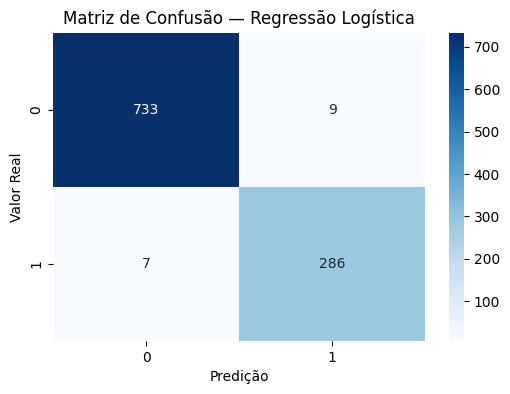

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_logreg)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão — Regressão Logística")
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.show()


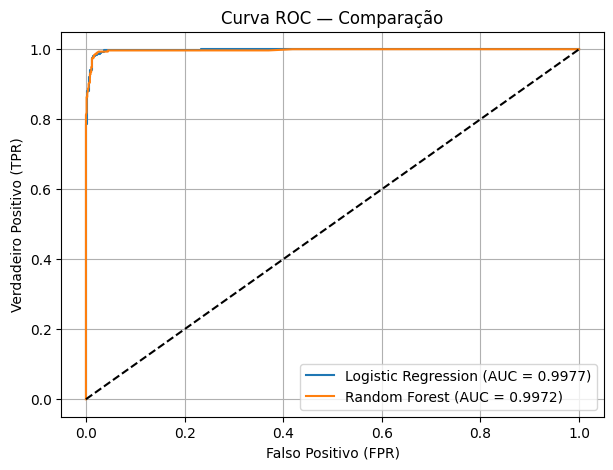

In [15]:
from sklearn.metrics import roc_curve, auc

logreg_probs = logreg.predict_proba(X_test_vec)[:,1]
rf_probs = rf.predict_proba(X_test_vec)[:,1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {auc_logreg:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})")

plt.plot([0,1], [0,1], "k--")
plt.title("Curva ROC — Comparação")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import pandas as pd

comparison = pd.DataFrame({
    "Métrica": ["Acurácia", "AUC"],
    "Regressão Logística": [acc_logreg, auc_logreg],
    "Random Forest": [acc_rf, auc_rf]
})

comparison


,Métrica,Regressão Logística,Random Forest
0,Acurácia,0.984541,0.980676
1,AUC,0.997677,0.997196


In [17]:
import joblib

joblib.dump(logreg, "spam_classifier_logreg.pkl")
joblib.dump(rf, "spam_classifier_rf.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("Modelos e vetorizador salvos com sucesso!")


Modelos e vetorizador salvos com sucesso!


In [18]:
def classify_email(text):
    clean = preprocess_text(text)
    vec = tfidf.transform([clean])
    pred = logreg.predict(vec)[0]
    prob = logreg.predict_proba(vec)[0][1]

    label = "SPAM" if pred == 1 else "HAM"
    return label, prob

# Testes
print(classify_email("Congratulations! You have won a free prize, click here"))
print(classify_email("Hi John, attached is the document you requested."))


('SPAM', np.float64(0.7914399020153459))
('HAM', np.float64(0.26930647430233))


In [20]:
print("===============================================")
print("TREINAMENTO FINALIZADO")
print("Melhor modelo: Regressão Logística")
print(f"Acurácia: {acc_logreg:.4f}")
print(f"AUC: {auc_logreg:.4f}")
print("Os modelos foram salvos e estão prontos para uso.")
print("===============================================")


TREINAMENTO FINALIZADO
Melhor modelo: Regressão Logística
Acurácia: 0.9845
AUC: 0.9977
Os modelos foram salvos e estão prontos para uso.
